# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

### 한글 폰트 설치 후 재시작

In [15]:
!brew install --cask font-nanum-gothic

==> Upgrading 1 outdated package:
font-nanum-gothic latest -> latest
==> Upgrading font-nanum-gothic
==> Cloning https://github.com/google/fonts.git
Updating /Users/cakenpeace/Library/Caches/Homebrew/Cask/font-nanum-gothic--git-sparse
==> Checking out branch main
Already on 'main'
Your branch is up to date with 'origin/main'.
HEAD is now at fc541cab Merge pull request #9089 from google/report-fix
==> Backing Font 'NanumGothic-Bold.ttf' up to '/opt/homebrew/Caskroom/font-nanum
==> Removing Font '/Users/cakenpeace/Library/Fonts/NanumGothic-Bold.ttf'
==> Backing Font 'NanumGothic-ExtraBold.ttf' up to '/opt/homebrew/Caskroom/font-
==> Removing Font '/Users/cakenpeace/Library/Fonts/NanumGothic-ExtraBold.ttf'
==> Backing Font 'NanumGothic-Regular.ttf' up to '/opt/homebrew/Caskroom/font-na
==> Removing Font '/Users/cakenpeace/Library/Fonts/NanumGothic-Regular.ttf'
==> Moving Font 'NanumGothic-Bold.ttf' to '/Users/cakenpeace/Library/Fonts/Nanum
==> Moving Font 'NanumGothic-ExtraBold.ttf' to '/

In [19]:
import matplotlib
matplotlib.matplotlib_fname()

'/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

['NanumSquareRound', 'NanumSquareRound', 'NanumGothic', 'NanumSquareRound', 'NanumSquareRoundOTF', 'NanumSquareRoundOTF', 'NanumGothic', 'NanumSquareRoundOTF', 'NanumSquareRound', 'NanumGothic', 'NanumSquareRoundOTF']


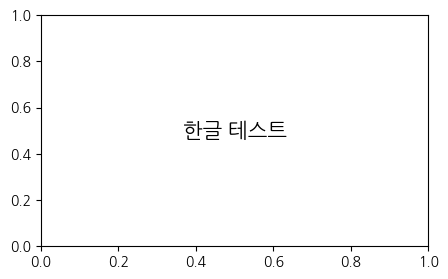

In [17]:
# Matplotlib에서 한글 폰트 사용 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')  # 나눔고딕으로 폰트 변경
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 폰트가 잘 적용되었는지 확인
print([f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name])

plt.figure(figsize=(5,3))
plt.text(0.5, 0.5, "한글 테스트", fontsize=15, ha='center', va='center')
plt.show()

## 1) 패키지 설치

In [3]:


import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

## 2) 네이버 영화 리뷰 데이터를 다운로드

In [1]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

NameError: name 'urllib' is not defined

## 3) 네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력

In [4]:
train_data = pd.read_table('ratings.txt')

train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 4) 총 리뷰 개수를 확인

In [5]:
print(f"총 리뷰 개수 : {len(train_data)}") # 리뷰 개수 출력

총 리뷰 개수 : 200000


## 5) 결측값 유무를 확인

In [6]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


## 6) 결측값이 존재하는 행을 제거

In [7]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


## 7) 다시 총 리뷰 개수 확인

In [8]:
print(f"총 리뷰 개수 : {len(train_data)}") # 리뷰 개수 출력

총 리뷰 개수 : 199992


## 8) 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행

In [9]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [10]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


## 9) 학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행

In [11]:
from tqdm import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


100%|██████████| 199992/199992 [05:12<00:00, 639.36it/s]


## 10) 각 리뷰의 길이 분포 시각화

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


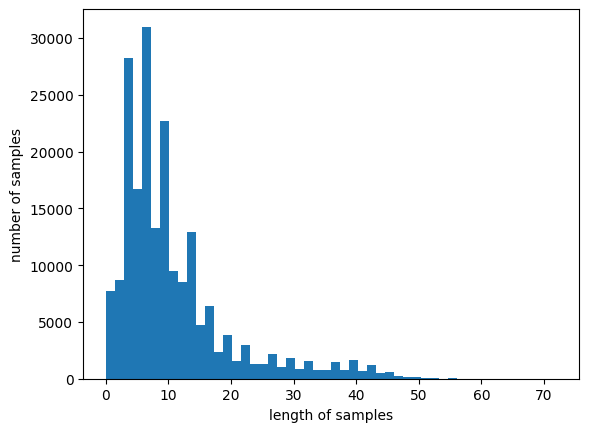

In [12]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 11) 토큰화 된 네이버 영화 리뷰 데이터로 Word2Vec 학습

- vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [13]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

## 12) 학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인

In [14]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

# 총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있습니다.

(16477, 100)

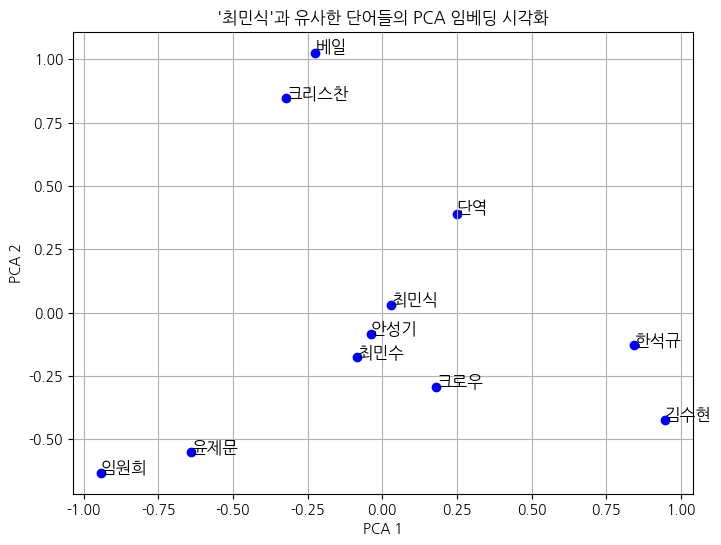

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# '최민식'과 유사한 단어 10개 가져오기
similar_words = model.wv.most_similar("최민식", topn=10)
words = [word for word, _ in similar_words]
words.append("최민식")  # 기준 단어도 포함

# 해당 단어들의 벡터 추출
word_vectors = np.array([model.wv[word] for word in words])

# PCA 변환 (100차원 -> 2차원)
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='blue')

# 각 포인트에 단어 라벨 추가
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("'최민식'과 유사한 단어들의 PCA 임베딩 시각화")
plt.grid(True)
plt.show()